In [1]:
import GPI_init_fit as gpi
import numpy as np
import matplotlib.pyplot as plt
import optimization.interpolated_univariate_spline as spline_func
from astropy.stats import bayesian_info_criterion as bic
from astropy.stats import akaike_info_criterion as aic

/home/blewis/anaconda3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
CuPy succesfully imported. Using GPU where applicable. Set use_gpu=False to override this functionality.


In [2]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
from astropy.io import fits
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'
jax.config.update("jax_enable_x64", True)
import pandas as pd
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

In [3]:
name = 'hd145560_H_pol'
fits_image_filepath = "/home/blewis/GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)

In [4]:
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]))
misc_params = Parameter_Index.misc_params

In [5]:
num_knots = 6

spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
disk_params = Parameter_Index.disk_params

image_data = pd.read_csv('image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "a_in", "a_out", "eccentricity", "ksi0", "gamma", "beta", "omega", "x_center", "y_center", "knots"]
row = image_data.loc[name]

disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]
misc_params['distance'] = row["Distance"]
spf_params['num_knots'] = num_knots
spf_params['knot_values'] = jnp.full(spf_params['num_knots'],0.5)
disk_params['alpha_in'] = row['a_in']
disk_params['alpha_out'] = row['a_out']
disk_params['e'] = row['eccentricity']
disk_params['ksi0'] = row['ksi0']
disk_params['gamma'] = row['gamma']
disk_params['beta'] = row['beta']
disk_params['omega'] = row['omega']
disk_params['x_center'] = 70
disk_params['y_center'] = 70

In [7]:
opt = Optimizer(disk_params, spf_params, psf_params, misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']
array_params = ['knot_values']
logscaled_params = []
opt.inc_bound_knots()
opt.scale_initial_knots(target_image)

soln = opt.scipy_optimize(fit_keys, logscaled_params, array_params, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
optimal_image = opt.model()
optimal_ll = opt.log_likelihood(target_image,err_map)

         Current function value: 42786.717182
         Iterations: 39
         Function evaluations: 2229
         Gradient evaluations: 111
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 42786.71718155184
        x: [ 8.645e+00 -6.065e-03 ...  7.592e-01  1.436e-01]
      nit: 39
      jac: [ 5.859e-03  0.000e+00 ...  2.246e-02  5.859e-03]
 hess_inv: [[ 5.118e-02  2.191e-03 ...  3.335e-03  3.538e-03]
            [ 2.191e-03  9.056e-03 ... -5.697e-04 -2.566e-04]
            ...
            [ 3.335e-03 -5.697e-04 ...  5.813e-03 -7.107e-04]
            [ 3.538e-03 -2.566e-04 ... -7.107e-04  9.308e-03]]
     nfev: 2229
     njev: 111


In [8]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 8.644732165148847, 'alpha_out': -0.00606510735884155, 'sma': 77.5602446602397, 'e': 0.013175424303444932, 'ksi0': 7.332754548036586, 'gamma': 1.5204352062817912, 'beta': -2.186720230400118, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 45.05737859348763, 'position_angle': 221.48977443396518, 'x_center': 72.99983224266566, 'y_center': 72.41084847033738, 'halfNbSlices': 25, 'omega': 2.475400158308459}
SPF Params: {'low_bound': Array(-0.69340183, dtype=float64), 'up_bound': Array(0.69340183, dtype=float64), 'num_knots': 6, 'knot_values': Array([1.94383333, 1.49288629, 1.28133756, 0.71263664, 0.47594115,
       0.08999882], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 120.44, 'pxInArcsec': 0.01414, 'nx': 140, 'ny': 140, 'halfNbSlices': 25, 'flux_scaling': Array(587.7661731, dtype=float64)}


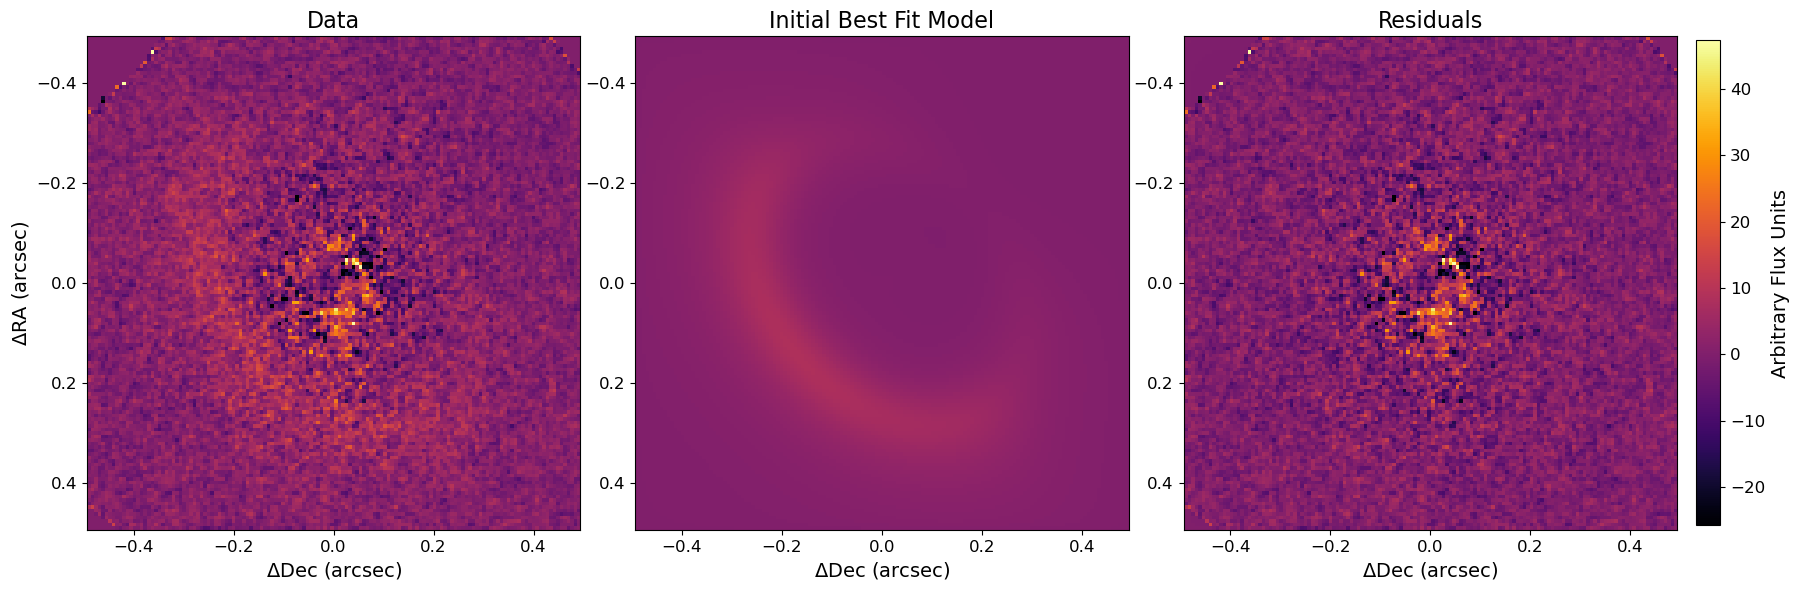

In [9]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("Initial Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=10)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_init_fit.png'.format(name))

133.9 46.1
[1.94383333 1.49288629 1.28133756 0.71263664 0.47594115 0.08999882]


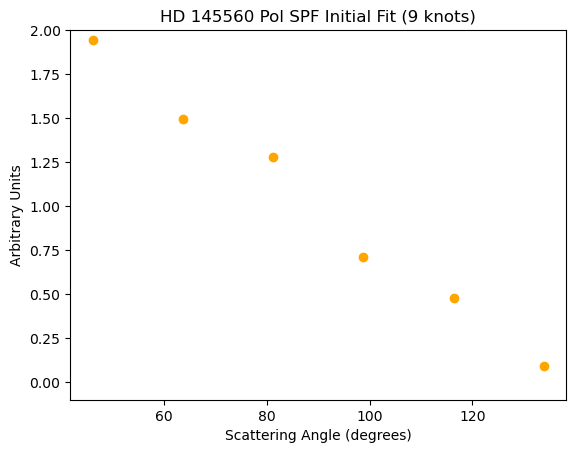

In [11]:
spf1 = opt.spf_params

hi = np.rad2deg(np.arccos(spf1['low_bound']))
lo = np.rad2deg(np.arccos(spf1['up_bound']))
print(hi,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
#plt.plot(np.linspace(0,180,100),func)
plt.scatter(np.linspace(lo,hi,num_knots),spf1['knot_values'],color='orange')

###CHANGE NAMES
plt.title('HD 145560 Pol SPF Initial Fit (9 knots)')
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.ylim(-0.1,2)
plt.savefig('../GPI_results/best_fits/hd145560_pol_spf_init.png',bbox_inches='tight')

In [ ]:
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']


bounds = ([0.1, -15,   0, 0,0.1,0.1,0.1,-20,   0, -20, 60,  60,    0, np.zeros(num_knots)],
          [15, -0.1, 150, 1, 15, 80, 15,380, 180, 380, 90,  90,  5e5, 1e4*np.ones(num_knots)])

mc_model = opt.mcmc(fit_keys, logscaled_params, array_params,target_image, err_map, bounds, nwalkers=100, niter=10000, burns=100)

In [ ]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()

In [ ]:
opt.print_params()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("MCMC Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_MCMC_fit.png'.format(name))

In [ ]:
samples = mc_model.sampler.get_chain()

In [ ]:
import matplotlib.pyplot as plt
labels = fit_keys.copy()[0:-1]
labels = ["$\alpha_{i}$","$\alpha_{o}$","Semimajor Axis (AU)","Eccentricity"]
labels.append('flux_scaling')
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
plt.tight_layout()

In [ ]:
mc_model.show_corner_plot(labels, truths=mc_soln)

In [ ]:
mc_model.sampler.get_autocorr_time()